# BetterWrapped

## Importing libraries

In [195]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pycountry

## Loading API-Keys

In [196]:
from dotenv import load_dotenv
load_dotenv()

True

## Importing Spotify data

### Reading data

In [197]:
df_raw = pd.DataFrame()
for file in [x for x in os.listdir("Spotify Extended Streaming History") if x.startswith("Streaming_History_Audio")]:
    df_raw = pd.concat([df_raw, pd.read_json("Spotify Extended Streaming History/"+file)])
df_raw.head(3)

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2018-11-12T19:09:12Z,"Android OS 8.0.0 API 26 (LGE, LG-H870)",0,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,None,...,NaN,NaN,NaN,clickrow,remote,False,False,False,NaN,False
1,2018-11-12T19:09:31Z,Partner sonos_ppc Sonos;Play5;;;,12500,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,spotify:track:6xtcFXSo8H9BZN637BMVKS,None,...,NaN,NaN,NaN,clickrow,endplay,False,False,False,NaN,False
2,2018-11-12T19:11:02Z,Partner sonos_ppc Sonos;Play5;;;,38500,CH,84.74.88.79,Happier,Marshmello,Happier,spotify:track:2dpaYNEQHiRxtZbfNsse99,None,...,NaN,NaN,NaN,clickrow,logout,False,False,False,NaN,False


### Formatting and cleaning data

In [198]:
df = df_raw.drop(columns=["episode_name", "episode_show_name", "spotify_episode_uri", "audiobook_title", "audiobook_uri", "audiobook_chapter_uri", "audiobook_chapter_title"])
df.rename(columns={"conn_country":"country_code", "ip_addr":"ip", "master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name", "master_metadata_album_album_name":"album_name"}, inplace=True)
df["ts"] = pd.to_datetime(df["ts"])
df = df.dropna(subset=["artist_name"])
df["s_played"] = df["ms_played"]/1000
df["min_played"] = df["s_played"]/60
df["h_played"] = df["min_played"]/60
df["d_played"] = df["h_played"]/24
df["country_name"] = df["country_code"].map(lambda x : pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else "Unbekannt")
df["date"] = df["ts"].dt.date
df["year"] = df["ts"].dt.year
df["month"] = df["ts"].dt.month
df["day"] = df["ts"].dt.day
df["time"] = df["ts"].dt.time
df["hour"] = df["ts"].dt.hour
df["minute"] = df["ts"].dt.minute
df["second"] = df["ts"].dt.second
df["spotify_track_uri"] = df["spotify_track_uri"].str.split(':').str[-1]
df.head(3)

,ts,platform,ms_played,country_code,ip,track_name,artist_name,album_name,spotify_track_uri,reason_start,...,d_played,country_name,date,year,month,day,time,hour,minute,second
0,2018-11-12 19:09:12+00:00,"Android OS 8.0.0 API 26 (LGE, LG-H870)",0,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,6xtcFXSo8H9BZN637BMVKS,clickrow,...,0.000000,Switzerland,2018-11-12,2018,11,12,19:09:12,19,9,12
1,2018-11-12 19:09:31+00:00,Partner sonos_ppc Sonos;Play5;;;,12500,CH,84.74.88.79,Let You Love Me,Rita Ora,Let You Love Me,6xtcFXSo8H9BZN637BMVKS,clickrow,...,0.000145,Switzerland,2018-11-12,2018,11,12,19:09:31,19,9,31
2,2018-11-12 19:11:02+00:00,Partner sonos_ppc Sonos;Play5;;;,38500,CH,84.74.88.79,Happier,Marshmello,Happier,2dpaYNEQHiRxtZbfNsse99,clickrow,...,0.000446,Switzerland,2018-11-12,2018,11,12,19:11:02,19,11,2


## Fetching data

In [199]:
import requests

In [200]:
if not "fetched_data" in os.listdir():
    os.mkdir("fetched_data")

### Fetching genres

https://developer.spotify.com/

In [201]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

In [202]:
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [203]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [204]:
def fetch_artist_genre(sp, artist, max_retries=5, initial_wait=5):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            genre = sp.search(q=artist, type="artist")["artists"]["items"][0]["genres"]
            return genre
        except (requests.exceptions.ReadTimeout, SpotifyException):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [205]:
if not "artist_genre.csv" in os.listdir("fetched_data"):
    artists = df["artist_name"].unique()
    list_artist_genre = [[artist, fetch_artist_genre(sp, artist)] for artist in artists]
    list_artist_genre = [[artist, ", ".join(genres)] for artist, genres in list_artist_genre]
    df_artist_genre = pd.DataFrame(list_artist_genre, columns=["artist_name", "genre"])
    df_artist_genre.to_csv("fetched_data/artist_genre.csv", index=False)
else:
    df_artist_genre = pd.read_csv("fetched_data/artist_genre.csv")

In [206]:
df = df.merge(df_artist_genre, on="artist_name", how="left")

### Fetching IP geolocation

https://github.com/ipinfo/python?tab=readme-ov-file#lite-api
https://ipinfo.io

In [207]:
import ipinfo

In [208]:
access_token = os.getenv("access_token")

In [209]:
handler = ipinfo.getHandler(access_token)

In [210]:
def fetch_ip_loc(handler, ip, max_retries=5, initial_wait=5, timeout=10):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            details = handler.getDetails(ip, timeout)
            return details
        except (requests.exceptions.ReadTimeout):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [211]:
if not "ip_loc.csv" in os.listdir("fetched_data"):
    list_ip_loc = [[ip, fetch_ip_loc(handler, ip).loc, fetch_ip_loc(handler, ip).city, fetch_ip_loc(handler, ip).region] for ip in df["ip"].unique()]
    df_ip_loc = pd.DataFrame(list_ip_loc, columns=["ip", "geo_loc", "city_name", "region_name"])
    df_ip_loc.to_csv("fetched_data/ip_loc.csv", index=False)
else:
    df_ip_loc = pd.read_csv("fetched_data/ip_loc.csv")

In [212]:
df = df.merge(df_ip_loc, on="ip", how="left")

In [213]:
df[["lat", "lon"]] = df["geo_loc"].str.split(",", expand=True)
df["lat"] = df["lat"].astype(float)
df["lon"] = df["lon"].astype(float)

### Fetching track infos (Paid)

https://rapidapi.com/soundnet-soundnet-default/api/track-analysis/

In [214]:
API_KEY = os.getenv("API_KEY")

In [215]:
url = "https://track-analysis.p.rapidapi.com/pktx/analysis"

headers = {
	"x-rapidapi-key": API_KEY,
	"x-rapidapi-host": "track-analysis.p.rapidapi.com"
}

In [216]:
if not "track_info.csv" in os.listdir("fetched_data"):
    df_track_info = pd.DataFrame()
    for track in df["track_name"].unique()[:3]:
        querystring  = {"song": track}
        response = requests.get(url, headers=headers, params=querystring).json()
        response["track_name"] = track
        df_track_info = pd.concat([df_track_info, pd.json_normalize(response)])
    df_track_info["loudness"] = df_track_info["loudness"].str.replace(" dB", "", regex=False).astype(int)
    df_track_info["s_duration"] = df_track_info["duration"].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
    df_track_info = df_track_info.drop(columns=["duration", "id"])
    df_track_info.to_csv("fetched_data/track_info.csv", index=False)
else:
    df_track_info = pd.read_csv("fetched_data/track_info.csv")

In [217]:
df = df.merge(df_track_info, on="track_name", how="left")

## Explaining data

### Quick overview

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85534 entries, 0 to 85533
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ts                 85534 non-null  datetime64[ns, UTC]
 1   platform           85534 non-null  object             
 2   ms_played          85534 non-null  int64              
 3   country_code       85534 non-null  object             
 4   ip                 85534 non-null  object             
 5   track_name         85534 non-null  object             
 6   artist_name        85534 non-null  object             
 7   album_name         85534 non-null  object             
 8   spotify_track_uri  85534 non-null  object             
 9   reason_start       85534 non-null  object             
 10  reason_end         85534 non-null  object             
 11  shuffle            85534 non-null  bool               
 12  skipped            85534 non-null  bool       

### Detailed description (add timestamp stuff!!)

| Attribute | Description |
|-----------|-------------|
| ts | This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time |
| platform | This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast). |
| ms_played | This field is the number of milliseconds the stream was played. |
| country_code | This field is the country code of the country where the stream was played (e.g. SE - Sweden). |
| ip | This field contains the IP address logged when streaming the track. |
| track_name | This field is the name of the track. |
| artist_name | This field is the name of the artist, band or podcast. |
| album_name | This field is the name of the album of the track. |
| spotify_track_uri  | A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>” <br><br> A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. |
| reason_start | This field is a value telling why the track started (e.g. “trackdone”) |
| reason_end | This field is a value telling why the track ended (e.g. “endplay”). |
| shuffle | This field has the value True or False depending on if shuffle mode was used when playing the track. |
| skipped | This field indicates if the user skipped to the next song |
| offline | This field indicates whether the track was played in offline mode (“True”) or not (“False”). |
| offline_timestamp | This field is a timestamp of when offline mode was used, if used. |
| incognito_mode | This field indicates whether the track was played during a private session (“True”) or not (“False”). |
| s_played | This field is the number of seconds the stream was played.|
| min_played | This field is the number of minutes the stream was played.|
| h_played | This field is the number of hours the stream was played.|
| d_played | This field is the number of days the stream was played.|
| country_name | This field is the country name of the country where the stream was played (e.g. Sweden - SE).|
| genre | This field is the genre of the artist |
| geo_loc | This field is the location coordinates in the format (latitude,longitude) where the stream was played. |
| city_name | This field is the city name of the city where the stream was played. |
| region_name | This field is the region name of the region where the stream was played. |
| lat | This field is the latitudinal location coordinates from where the stream was played. |
| lon | This field is the longitudinal location coordinates from where the stream was played. |

### Translation from attributes to displayable names

In [ ]:
dict_att_disp = {
    "artist_name":"Artist",
    "track_name":"Track",
    "genre":"Genre",
    "album_name":"Album",
    "country_name":"Country",
    "region_name":"Region",
    "city_name":"City",
    "platform":"Platform",
    "s_played":"Seconds",
    "min_played":"Minutes",
    "h_played":"Hours",
    "d_played":"Days"
}

## Exploring static data

### Your Spotify usage

In [ ]:
print("You started using Spotify in", df["ts"].min().date())
print("You listened to ", df.shape[0], " tracks, over the course of ", (df["ts"].max() - df["ts"].min()).days, " days (", round((df["ts"].max() - df["ts"].min()).days/365, 2), " years)", sep="")
print("You listened to Spotify for ", df["ms_played"].sum()//3600000, " hours (", df["ms_played"].sum()//3600000//24, " days)", sep="")

You started using Spotify in 2018-11-12
You listened to 85534 tracks, over the course of 2542 days (6.96 years)
You listened to Spotify for 2567 hours (106 days)


### Your "favourites"

In [ ]:
def get_top_data_raw(attribute, sorting_value, time_format, top_count, start, end):
    if start == "first": start = df["ts"].min()
    if end == "last": end = df["ts"].max()
    if sorting_value == "track_count":
        if attribute == "genre":
            return (df[(df["ts"] > start) & (df["ts"] < end)][attribute].str.split(", ").explode().value_counts()[:top_count].reset_index())
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][attribute].value_counts()[:top_count].reset_index()
    elif sorting_value == "listening_time":
        if attribute == "genre":
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].assign(genre=df[attribute].str.split(", ")).explode(attribute).groupby(attribute)[time_format].sum().sort_values(ascending=False)[:top_count].reset_index().round(1)
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].groupby(attribute).sum().sort_values(time_format, ascending=False)[:top_count].reset_index().round(1)

In [ ]:
def bar_plot(categories, values, title="Bar Chart", x_label="Categories", y_label="Values"):
    fig, ax = plt.subplots(figsize=(7, 4))
    x_pos = np.arange(len(categories))
    bar_artists = ax.bar(x_pos, values, color="#4C72B0", edgecolor="black")

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories)

    for bar in bar_artists:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom"
        )

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    return fig, ax, bar_artists

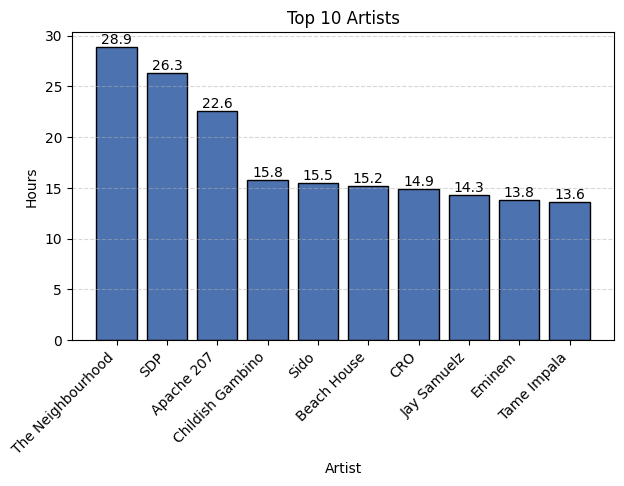

In [ ]:
attribute = "artist_name" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 10 #the top n will be returned
sorting_value = "listening_time" #track_count or listening_time
time_format = "h_played" #s_played, min_played, h_played, d_played
start = "first" #start="year-month-day" or "first"
end = "last" #end="year-month-day" or "last"

x = get_top_data_raw(attribute, sorting_value, time_format, top_count, start, end)[attribute]
y = get_top_data_raw(attribute, sorting_value, time_format, top_count, start, end)[time_format]
fig, ax, bars = bar_plot(x, y, f"Top {top_count} {dict_att_disp[attribute]}s", dict_att_disp[attribute], dict_att_disp[time_format])
plt.show()

## Exploring dynamic data

In [ ]:
#listening_dates_counted = df[df["artist_name"] == "Sido"]["ts"].dt.date.value_counts().sort_index()
listening_dates_counted = df[df["artist_name"] == "Sido"]
listening_dates_counted["date"] = listening_dates_counted["ts"].dt.date
listening_dates_counted = listening_dates_counted.groupby("date")["s_played"].sum()
listening_dates_counted

C:\Users\Fabian\AppData\Local\Temp\ipykernel_16400\3691092215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listening_dates_counted["date"] = listening_dates_counted["ts"].dt.date


date
2019-03-01    204.213
2019-06-28     26.043
2019-11-25    474.314
2019-11-26    237.157
2019-11-28    474.314
               ...   
2025-09-15    432.573
2025-09-16    169.500
2025-09-21    226.653
2025-09-22     45.357
2025-10-29    437.294
Name: s_played, Length: 140, dtype: float64

In [ ]:
rng_dates = full_range = pd.date_range(start=listening_dates_counted.index.min(), end=listening_dates_counted.index.max(), freq="d")
listening_dates_counted = listening_dates_counted.reindex(rng_dates, fill_value=0).reset_index()
listening_dates_counted.columns = ["date", "count"]
listening_dates_counted["date"] = pd.to_datetime(listening_dates_counted["date"])
listening_dates_counted.head(3)

,date,count
0,2019-03-01,204.213
1,2019-03-02,0.000
2,2019-03-03,0.000


In [ ]:
listening_dates_counted_month = listening_dates_counted.groupby(listening_dates_counted["date"].dt.to_period("M"))["count"].sum().reset_index()
listening_dates_counted_year = listening_dates_counted.groupby(listening_dates_counted["date"].dt.year)["count"].sum().reset_index()
listening_dates_counted_year.head(3)

,date,count
0,2019,1416.041
1,2020,3680.212
2,2021,211.259


In [ ]:
weekday_names = {0: "Monday",
                 1: "Tuesday",
                 2: "Wednesday",
                 3: "Thursday",
                 4: "Friday",
                 5: "Saturday",
                 6: "Sunday"
}

In [ ]:
month_names = {1: "January",
               2: "February",
               3: "March",
               4: "April",
               5: "May",
               6: "June",
               7: "July",
               8: "August",
               9: "September",
               10: "October",
               11: "November",
               12: "December"
}

In [ ]:
listening_dates_counted_average_monthday = listening_dates_counted.groupby(listening_dates_counted["date"].dt.day)["count"].sum().reset_index()
listening_dates_counted_average_monthday.columns = ["monthday", "count"]
listening_dates_counted_average_weekday = listening_dates_counted.groupby(listening_dates_counted["date"].dt.weekday)["count"].sum().reset_index()
listening_dates_counted_average_weekday["date"] = listening_dates_counted_average_weekday["date"].map(weekday_names)
listening_dates_counted_average_weekday.columns = ["weekday", "count"]
listening_dates_counted_average_month = listening_dates_counted.groupby(listening_dates_counted["date"].dt.month)["count"].sum().reset_index()
listening_dates_counted_average_month["date"] = listening_dates_counted_average_month["date"].map(month_names)
listening_dates_counted_average_month.columns = ["month", "count"]
listening_dates_counted_average_month.head(3)

,month,count
0,January,718.604
1,February,9253.038
2,March,4067.361


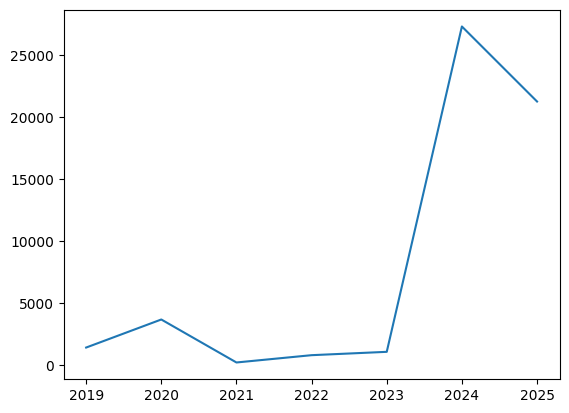

In [ ]:
x = listening_dates_counted_year["date"]
y = listening_dates_counted_year["count"]
plt.plot(x, y)
plt.show()